# Import Libraries

In [1]:
from datasets import load_dataset, Dataset as hugging_dataset_cls
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Literal

/Users/danielplotkin/miniconda3/envs/msai349/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

In [2]:
# Load the emoji dataset
dataset = load_dataset("valhalla/emoji-dataset")

# Check the data
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2749
    })
})


# Plot Examples

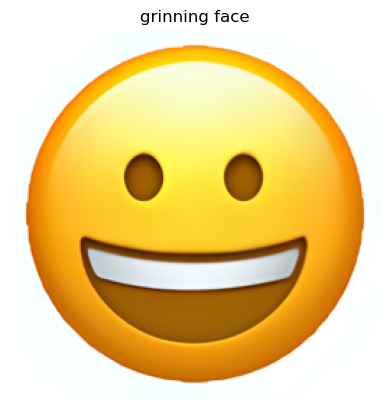

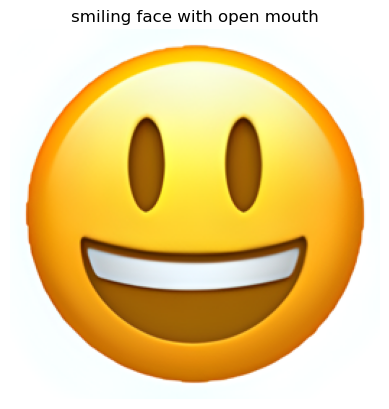

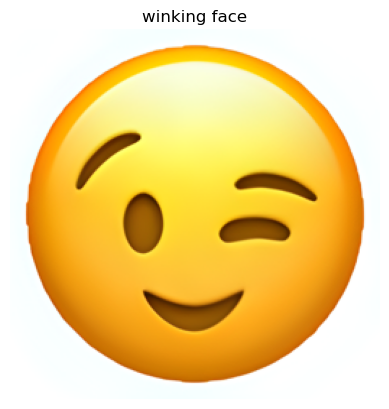

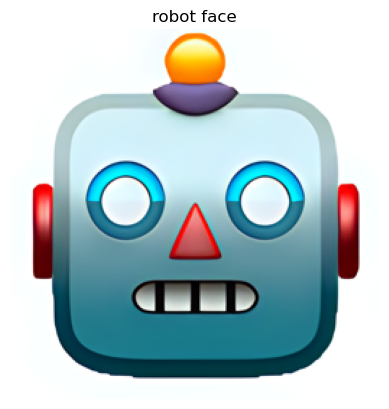

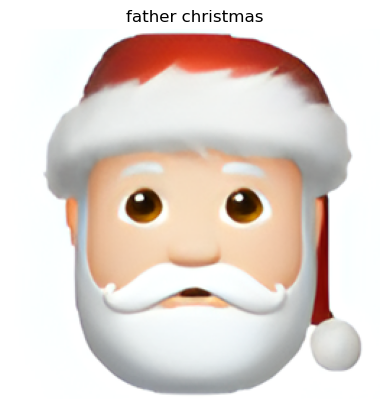

In [3]:
# Parse features and labels
for i in range(5):
    images = dataset['train']['image']
    text = dataset['train']['text']
    plt.imshow(images[i])
    plt.title(text[i])
    plt.axis("off")
    plt.show()

# Prepare Dataset

## Train Val Test Split

In [5]:
faces_dataset = dataset['train'].filter(lambda x: "face" in x['text'])

In [6]:
faces_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 204
})

In [7]:
train_test = faces_dataset.train_test_split(test_size=0.2)
train_val = train_test['train'].train_test_split(test_size=0.25)
dataset_split = {
    'train': train_val['train'],
    'val': train_val['test'],
    'test': train_test['test']
}
dataset_split

{'train': Dataset({
     features: ['image', 'text'],
     num_rows: 122
 }),
 'val': Dataset({
     features: ['image', 'text'],
     num_rows: 41
 }),
 'test': Dataset({
     features: ['image', 'text'],
     num_rows: 41
 })}

In [8]:
dataset_split['train']

Dataset({
    features: ['image', 'text'],
    num_rows: 122
})

## Create Custom Dataset

In [9]:
class EmojiDataset(Dataset):
    def __init__(self, data: hugging_dataset_cls):
        self.data = data
        self.X = data['image']
        self.y = data['image']

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        to_tensor = transforms.ToTensor()
        img_X = to_tensor(self.X[idx]).reshape(-1)
        img_y = to_tensor(self.y[idx]).reshape(-1)
        return img_X, img_y

## Create Dataset Objects

In [10]:
train_ds = EmojiDataset(dataset_split['train'])
val_ds = EmojiDataset(dataset_split['val'])
test_ds = EmojiDataset(dataset_split['test'])

## Batch into DataLoaders

In [11]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

for batch_X, batch_y in train_loader:
    print(batch_X.shape)
    print(batch_y.shape)
    break

torch.Size([8, 196608])
torch.Size([8, 196608])


/Users/danielplotkin/miniconda3/envs/msai349/lib/python3.12/site-packages/torchvision/transforms.py:36: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


# Create Autoencoder

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(256*256*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256*256*3),
            nn.Sigmoid()
        )

    def forward(self, X):
        x = self.encoder(X)
        return self.decoder(x)

# Train Model

## Create Trainer

In [13]:
class Trainer:
    def __init__(self, model: nn.Module, optimizer: optim.Optimizer, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, loss_fn: nn.MSELoss = nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.n_epochs = n_epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def train(self):
        train_losses, val_losses = [], []
        for epoch in range(1, self.n_epochs+1):
            print(f"Epoch {epoch}/{self.n_epochs}:")
            train_epoch_loss = self._train_single_epoch()
            val_epoch_loss = self._valid_single_epoch(self.val_loader)
            train_losses.append(train_epoch_loss)
            val_losses.append(val_epoch_loss)
            print("\n")

        return {
            "train_losses": train_losses,
            "val_losses": val_losses
        }
    
    def evaluate(self, loader_type: Literal['validation', 'test']) -> float:
        if loader_type == "test":
            loader = self.test_loader
        else:
            loader = self.val_loader

        return self._valid_single_epoch(loader, label=loader_type.capitalize())

    def _train_single_epoch(self) -> float:
        self.model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
        for i, (input_data, output_data) in pbar:
            batch_num = i+1
            # Zero out grads
            self.optimizer.zero_grad()

            # Forward pass
            output = self.model(input_data)
            loss = self.loss_fn(output, output_data)
            running_loss += loss.item()

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Log
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg Train Loss: {avg_loss:.4f}")

        return avg_loss
    
    @torch.no_grad()
    def _valid_single_epoch(self, loader: DataLoader, label: str = "Validation") -> float:
        self.model.eval()
        running_loss = 0.0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for i, (input_data, output_data) in pbar:
            batch_num = i+1
            # Forward pass
            output = self.model(input_data)
            loss = self.loss_fn(output, output_data)
            running_loss += loss.item()

            # Log
            avg_loss = running_loss / batch_num
            pbar.set_description(f"Avg {label} Loss: {avg_loss:.4f}")

        return avg_loss

## Train

In [14]:
model = AutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    n_epochs=20,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)

history = trainer.train()

Epoch 1/20:


Avg Validation Loss: 0.0599: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]




Epoch 2/20:


Avg Validation Loss: 0.0523: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s]




Epoch 3/20:


Avg Validation Loss: 0.0463: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]




Epoch 4/20:


Avg Validation Loss: 0.0413: 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]




Epoch 5/20:


Avg Validation Loss: 0.0373: 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]




Epoch 6/20:


Avg Validation Loss: 0.0369: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]




Epoch 7/20:


Avg Validation Loss: 0.0342: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]




Epoch 8/20:


Avg Validation Loss: 0.0340: 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]




Epoch 9/20:


Avg Validation Loss: 0.0382: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]




Epoch 10/20:


Avg Validation Loss: 0.0338: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]




Epoch 11/20:


Avg Validation Loss: 0.0329: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]




Epoch 12/20:


Avg Validation Loss: 0.0330: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]




Epoch 13/20:


Avg Validation Loss: 0.0311: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]




Epoch 14/20:


Avg Validation Loss: 0.0343: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]




Epoch 15/20:


Avg Validation Loss: 0.0324: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]




Epoch 16/20:


Avg Validation Loss: 0.0324: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]




Epoch 17/20:


Avg Validation Loss: 0.0342: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]




Epoch 18/20:


Avg Validation Loss: 0.0356: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]




Epoch 19/20:


Avg Validation Loss: 0.0331: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]




Epoch 20/20:


Avg Validation Loss: 0.0315: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


## Plot Training

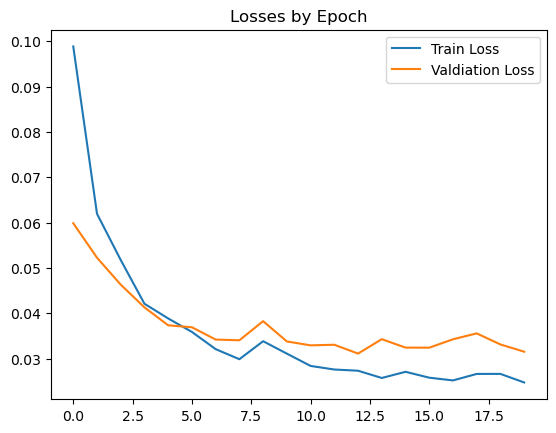

In [15]:
train_losses = history['train_losses']
val_losses = history['val_losses']
plt.title("Losses by Epoch")
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valdiation Loss')
plt.legend()
plt.show()